### Load Dataset & Libraries

In [ ]:
!pip install -q kaggle

In [ ]:
import numpy as np
from PIL import Image

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d duttadebadri/image-classification

100% 2.33G/2.34G [00:33<00:00, 123MB/s]
100% 2.34G/2.34G [00:33<00:00, 74.9MB/s]


In [ ]:
!unzip -q image-classification.zip

In [ ]:
!rm image-classification.zip

### Gaussian Noise

In [ ]:
def generate_gaussian(mean=0, standard_deviation=1):
    """Function to generate random numbers from a Gaussian distribution
    Parameters:
    - mean: the mean of the distribution (default: 0)
    - standard_deviation: the standard deviation of the distribution (default: 1)
    Returns:
    - A random number from the Gaussian distribution with the specified mean and standard deviation
    """
    u1 = np.random.random()
    u2 = np.random.random()

    z = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)

    return z * standard_deviation + mean

In [ ]:
def add_gaussian_noise_to_image(image, mean=0, standard_deviation=1):
    """Function to add Gaussian noise to an image
    Parameters:
    - image: The input image to which the noise will be added
    - mean: The mean of the Gaussian distribution used to generate the noise (default: 0)
    - standard_deviation: The standard deviation of the Gaussian distribution used to generate the noise (default: 1)
    Returns:
    - An image with Gaussian noise added to it"""
    image = np.array(image)
    noise = np.vectorize(generate_gaussian)(
        np.full(image.shape, mean), np.full(image.shape, standard_deviation)
    )
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

### SVD

In [ ]:
def power_iteration(A, num_simulations=100):
    """
    Perform power iteration to estimate the dominant eigenvalue and eigenvector of a given matrix.

    Parameters:
    - A (numpy.ndarray): The input matrix.
    - num_simulations (int): The number of iterations to perform (default: 100).

    Returns:
    - tuple: A tuple containing the estimated eigenvalue and eigenvector.
    """
    b = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        b_k1 = np.dot(A, b)

        b_k1_norm = 0
        for e in b_k1:
            b_k1_norm += e**2

        b_k1_norm = np.sqrt(b_k1_norm)

        b = b_k1 / b_k1_norm

    return np.dot(np.dot(A, b), b) / np.dot(b, b), b


def power_iteration_deflation(A, num_simulations=100):
    """
    Parameters:
    - A: The input matrix for which the dominant eigenvalue and eigenvector will be estimated.
    - num_simulations: The number of iterations to perform in the power iteration process (default: 100).

    Returns:
    - A tuple containing the estimated dominant eigenvalue and eigenvector.
    """
    n = A.shape[0]
    eig_vals = np.zeros(n)
    eig_vecs = np.zeros((n, n))

    for i in range(n):
        eig_val, eig_vec = power_iteration(A, num_simulations)

        eig_vals[i] = eig_val
        eig_vecs[:, i] = eig_vec

        A = A - eig_val * np.outer(eig_vec, eig_vec)

    return eig_vals, eig_vecs

In [ ]:
def svd(A):
    """
    Parameters:
    - A: The input matrix for which the SVD will be computed.

    Returns:
    - A tuple containing the matrices U, s, and V^T, representing the SVD of `A`.
    """
    AT = A.T
    ATA = AT.dot(A)
    eig_vals, eig_vecs = power_iteration_deflation(ATA)

    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_indices]
    eig_vecs = eig_vecs[:, sorted_indices]

    s = np.sqrt(eig_vals)

    V = eig_vecs

    U = A.dot(V) / s

    return U, s, V.T

In [ ]:
def denoise_image_per_channel(image, k):
    """
    Parameters:
    - image: The input image channel to be denoised.
    - k: The number of singular values to keep for denoising.

    Returns:
    - An Image object representing the denoised image.
    """
    U, sigma, V = svd(image)
    U = U[:, :k]
    sigma = sigma[:k]
    V = V[:k, :]
    denoised_image = np.dot(U, np.dot(np.diag(sigma), V))
    denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)
    return Image.fromarray(denoised_image)

In [ ]:
def denoise_rgb_image(image, k):
    """
    Parameters:
    - image: The input RGB image to be denoised.
    - k: The number of singular values to keep for each color channel.

    Returns:
    - An RGB image with reduced noise.
    """
    image = np.array(image).astype(np.float64)
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    r_denoised = denoise_image_per_channel(r, k)
    g_denoised = denoise_image_per_channel(g, k)
    b_denoised = denoise_image_per_channel(b, k)
    return Image.merge("RGB", (r_denoised, g_denoised, b_denoised))

### Test on Dataset

In [ ]:
def get_concat_h(im1, im2, im3):
    dst = Image.new("RGB", (im1.width + im2.width + im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    return dst

In [ ]:
import os

PATH = "./images/images/architecure/"

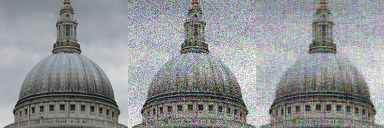

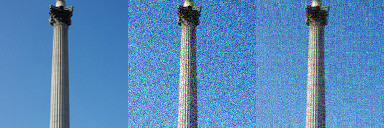

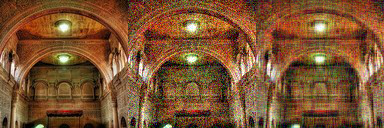

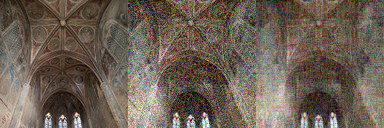

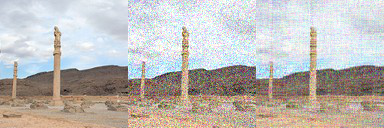

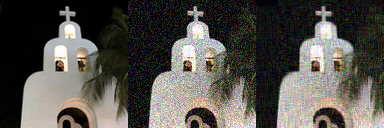

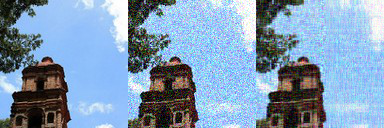

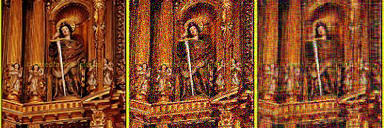

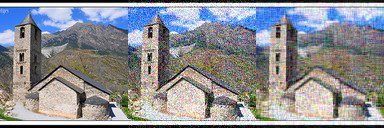

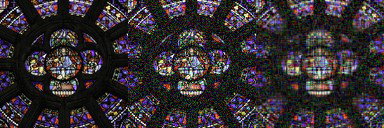

In [ ]:
ls = os.listdir(PATH)
for i in range(10):
    file_path = PATH + np.random.choice(ls)
    image = Image.open(file_path)
    noisy_image = add_gaussian_noise_to_image(image, mean=10, standard_deviation=30)
    denoised_image = denoise_rgb_image(noisy_image, k=20)
    get_concat_h(image, noisy_image, denoised_image).show()

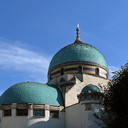

In [ ]:
random_image = Image.open(PATH + np.random.choice(ls))
random_image.show()

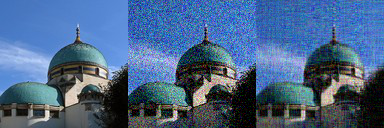

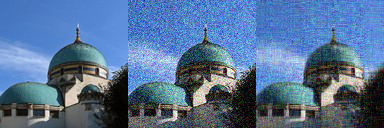

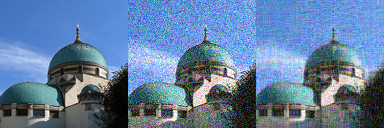

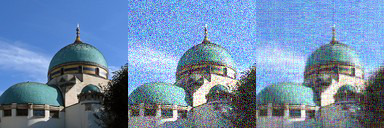

In [ ]:
mean_vals = [-20, 0, 20, 40]

for i in mean_vals:
    noisy_image = add_gaussian_noise_to_image(
        random_image, mean=i, standard_deviation=30
    )
    denoised_image = denoise_rgb_image(noisy_image, k=20)
    get_concat_h(random_image, noisy_image, denoised_image).show()

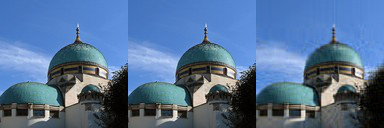

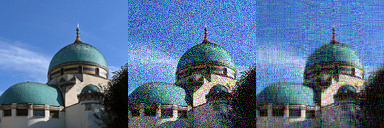

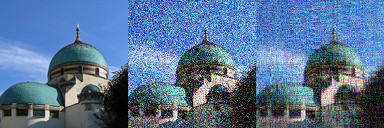

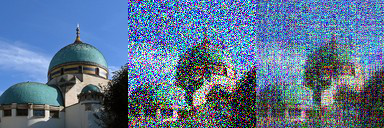

In [ ]:
var_vals = [0, 30, 50, 100]

for i in var_vals:
    noisy_image = add_gaussian_noise_to_image(
        random_image, mean=0, standard_deviation=i
    )
    denoised_image = denoise_rgb_image(noisy_image, k=20)
    get_concat_h(random_image, noisy_image, denoised_image).show()

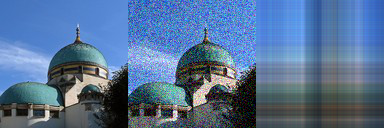

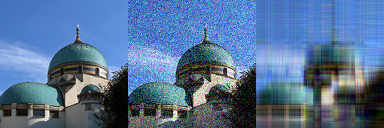

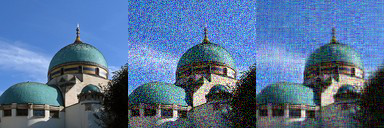

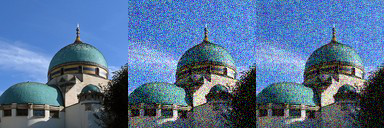

In [ ]:
k_vals = [1, 5, 20, 50]

for i in k_vals:
    noisy_image = add_gaussian_noise_to_image(
        random_image, mean=0, standard_deviation=30
    )
    denoised_image = denoise_rgb_image(noisy_image, k=i)
    get_concat_h(random_image, noisy_image, denoised_image).show()